In [17]:
import torch
from PIL import Image
from torchvision import transforms, utils
from torch.nn import functional as F
from dssnet import build_model
from tools.visual import plot_image, make_simple_grid
from tools.crf_process import crf
%matplotlib inline

#### 1. path and configuration

Note: you can change use_cuda to False with cpu version

In [18]:
img_path = './png/demo_img.jpg'
pre_trained = './weights/final.pth'

select = [1, 2, 3, 6] # inference: choose the side map (see paper)
use_cuda = True
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

#### 2: Image Preprocess

In [19]:
img = Image.open(img_path)

img_shape = (img.size[1], img.size[0])
print('image size (HxW): ', img_shape)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(img).unsqueeze(0).to(device)

image size (HxW):  (400, 300)


#### 3. network process

In [20]:
net = build_model().to(device)
net.load_state_dict(torch.load(pre_trained))

with torch.no_grad():
    prob_pred = net(image)
    prob_final = torch.mean(torch.cat([prob_pred[i] for i in select], dim=1), dim=1, keepdim=True)

# upsampling to original size
prob_pred = [F.interpolate(prob, img_shape, mode='bilinear', align_corners=True).cpu().data.squeeze(0) for prob in prob_pred]
prob_final = F.interpolate(prob_final, img_shape, mode='bilinear', align_corners=True).cpu().data.squeeze(0)

#### 4. show results

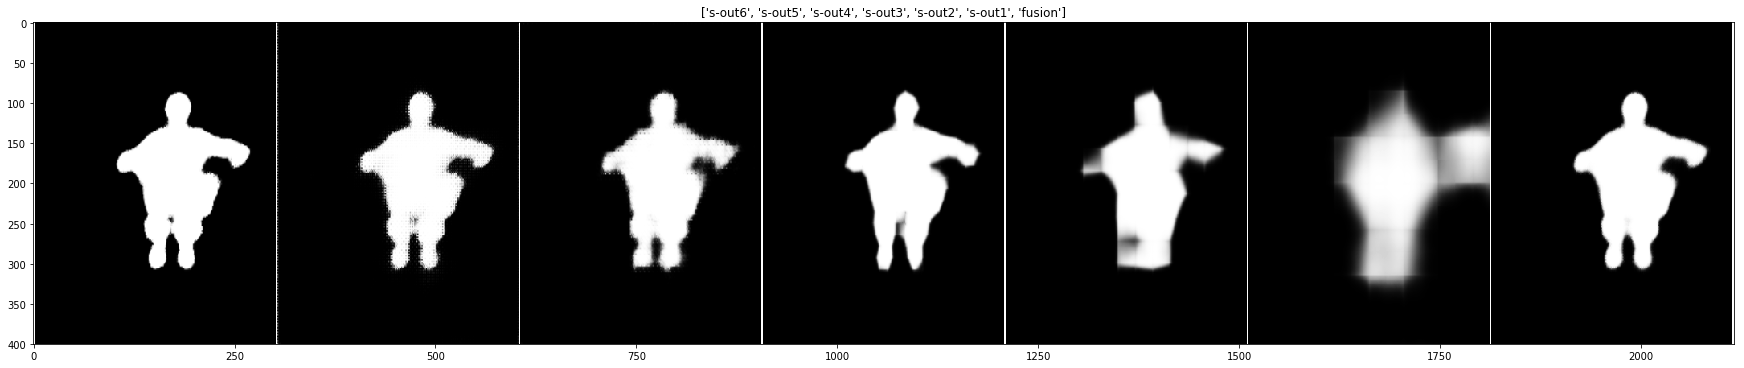

In [21]:
# output of sides and fusion
ratio = 160/(img_shape[1]*7)
title = ['s-out6', 's-out5', 's-out4', 's-out3', 's-out2', 's-out1', 'fusion']
plot_image(make_simple_grid(prob_pred), (img_shape[0]*ratio, 160), title=title)

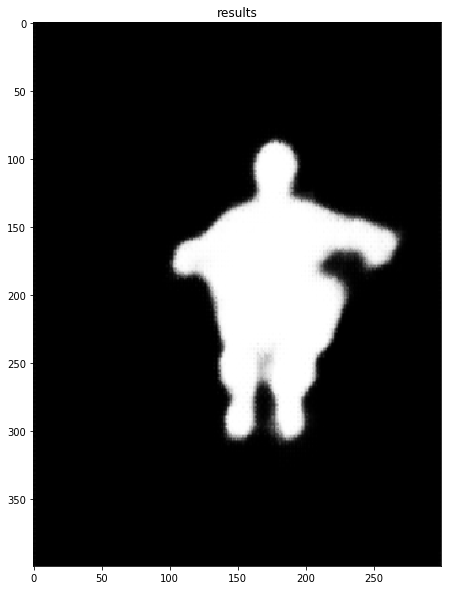

In [22]:
# results
plot_image(prob_final, (img_shape[0]/30, img_shape[1]/30), 'results')

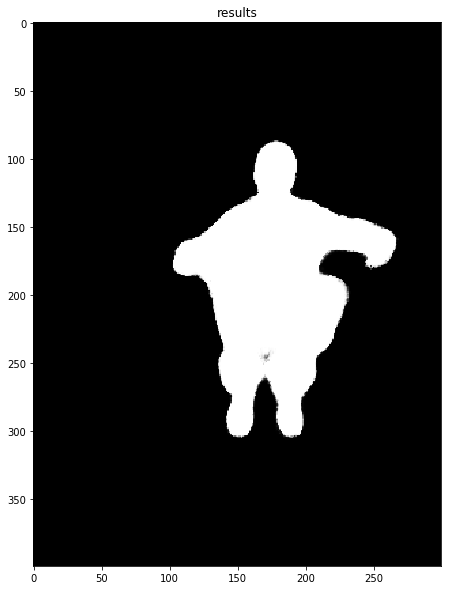

In [23]:
# crf process
prob_final = crf(img, prob_final)
plot_image(prob_final, (img_shape[0]/30, img_shape[1]/30), 'results')